In [150]:
%pylab inline
import gc
import scipy
import fitsio
import catutil
import imgSimutil
import numpy as np
from fpfs import fpfsBase

import numpy.lib.recfunctions as rfn

pltDir='plot/errors/'
vdir='outBasic-var7em3'

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


# Prepare three catalogs

In [171]:
def wlmask(dd,doWL=False):
    centDis=  np.sqrt((dd['base_SdssCentroid_y']%ngrid-ngrid/2)**2. +
              (dd['base_SdssCentroid_x']%ngrid-ngrid/2)**2.)
    mask =  (dd['base_ClassificationExtendedness_value'] > 0) &\
        (~np.isnan(dd['modelfit_CModel_instFlux']))&\
        (~np.isnan(dd['modelfit_CModel_instFluxErr'])) &\
        (~np.isnan(dd['ext_shapeHSM_HsmShapeRegauss_resolution'])) &\
        (~np.isnan(dd['ext_shapeHSM_HsmPsfMoments_xx'])) &\
        (~np.isnan(dd['ext_shapeHSM_HsmPsfMoments_yy'])) &\
        (~np.isnan(dd['ext_shapeHSM_HsmPsfMoments_xy'])) &\
        (~np.isnan(dd['base_Variance_value']))&\
        (~np.isnan(dd['modelfit_CModel_instFlux']))&\
        (~np.isnan(dd['modelfit_CModel_instFluxErr']))&\
        (~np.isnan(dd['ext_shapeHSM_HsmShapeRegauss_resolution']))&\
        (dd['deblend_nChild']  ==  0) &\
        (centDis<5.)
    dd   =   dd[mask]
    centDis= centDis[mask]
    ipos =   np.int_(dd['base_SdssCentroid_y']//64)*100+np.int_(dd['base_SdssCentroid_x']//64)
    inds =   np.lexsort([centDis, ipos])
    dd   =   dd[inds]
    ipos =   ipos[inds]
    inds_unique =   np.unique(ipos, return_index=True)[1]
    dd   =  dd[inds_unique]
    if doWL:
        wlmsk=   (catutil.get_imag(dd) < 24.5) & \
            (catutil.get_abs_ellip(dd) <= 2.)   & \
            (catutil.get_res(dd) >= 0.3)        & \
            (catutil.get_snr(dd) >= 10.)        & \
            (catutil.get_logb(dd)<= -0.38)
        return dd[wlmsk]
    else:
        return dd

0.2978854720260368


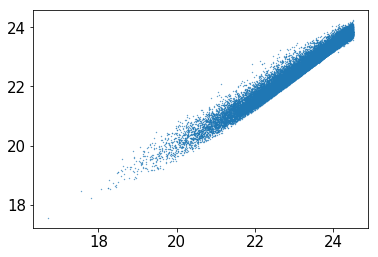

In [206]:
del rgs1,rgs2,mmsN
gc.collect()
rgs1=[]
rgs2=[]
mmsN=[]
for igroup in range(8):
    # read galaxy image
    ifield=igroup*250
    fname=os.path.join(vdir,'src-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    src1=fitsio.read(fname)
    src1=wlmask(src1,doWL=True)
    rgs1.append(src1)
    ids1=np.int_(src1['base_SdssCentroid_y']//64)*100+np.int_(src1['base_SdssCentroid_x']//64)
    
    fname=os.path.join(vdir,'src-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
    src2=fitsio.read(fname)
    src2=wlmask(src2)
    ids2=np.int_(src2['base_SdssCentroid_y']//64)*100+np.int_(src2['base_SdssCentroid_x']//64)
    src2=src2[np.in1d(ids2,ids1,assume_unique=True)]
    rgs2.append(src2)
    
    fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    mm=fitsio.read(fname)[ids1]
    mmsN.append(mm)
    
    del mm,src1,src2,fname,ifield
    gc.collect()
rgs1=rfn.stack_arrays(rgs1,usemask=False)
rgs2=rfn.stack_arrays(rgs2,usemask=False)
mmsN=rfn.stack_arrays(mmsN,usemask=False)
print(np.std(bN['fpfs_e1'])/np.average(bN['fpfs_RE']))
C=2000.
bN=fpfsBase.fpfsM2E(mmsN,C,rev=True)
if True:
    plt.scatter(catutil.get_imag(rgs1),27-1.25*log10(mmsN['fpfs_M00']),s=0.1)

# Get Optimal weight

In [221]:
def get_weight(rgs,tree,hdat):
    snr=catutil.get_snr(rgs)
    res=catutil.get_res(rgs)
    xyDat   =   np.vstack([np.log10(snr),np.log10(res)]).T
    dis,inds=tree.query(xyDat,k=1)
    weight=hdat['ishape_hsm_regauss_derived_shape_weight'][inds]
    return weight

In [222]:
fname=os.path.join(os.environ['homeWrk'],\
       'S16ACatalogs/S16AStandardCalibrated/field/GAMA09H_calibrated.fits')
hdat=fitsio.read(fname)
snr=catutil.get_snr(hdat)
res=catutil.get_res(hdat)
xyRef=np.vstack([np.log10(snr),np.log10(res)]).T
tree    =   scipy.spatial.cKDTree(xyRef)

In [223]:
w1=get_weight(rgs1,tree,hdat)
w2=get_weight(rgs2,tree,hdat)

In [224]:
response=(np.average(rgs2['ext_shapeHSM_HsmShapeRegauss_e1'],weights=w2)\
          -np.average(rgs1['ext_shapeHSM_HsmShapeRegauss_e1'],weights=w1))/0.04
g1=rgs1['ext_shapeHSM_HsmShapeRegauss_e1']/response

In [225]:
np.sqrt(np.average(g1**2, weights=w1))

0.2878575071208501